In [6]:
"""
Zuerst stellen wir sicher, dass die notwendigen Pakete installiert sind und importieren diese:
"""
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from torch.utils.data import DataLoader
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score



import os
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()

In [7]:
"""
Nun definieren wir Transformatoren für die Daten, laden das Dataset und teilen diese in Trainings- und Validierungsätze auf:
"""
# Definieren Sie Transformationen für das Training und die Validierung
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        # transforms.Normalize([0.7438, 0.5865, 0.5869],
        #                     [0.0804, 0.1076, 0.1202])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize([0.7438, 0.5865, 0.5869],
        #                     [0.0804, 0.1076, 0.1202])
    ])
}

# Laden des FGVC-Aircraft-Datensatzes
train_dataset = torchvision.datasets.ImageFolder(root='Data/Train', transform=transform["train"])
test_dataset = torchvision.datasets.ImageFolder(root='Data/Test', transform=transform["test"])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [20]:
"""
Berechne Mean und Std für Normalize() auf Basis deines Trainingsdatensatzes
"""
from torchvision import \
    datasets, \
    transforms
from torch.utils.data import \
    DataLoader
import \
    torch
import \
    numpy as np

# Nur Resize + ToTensor, keine Augmentierung!
tmp_transform = transforms.Compose(
    [
        transforms.Resize(
            (224,
             224)),
        transforms.ToTensor()
    ])

# Dataset laden
tmp_dataset = datasets.ImageFolder(
    root='Data/Train',
    transform=tmp_transform)
tmp_loader = DataLoader(
    tmp_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2)

# Initialisieren
mean = 0.
std = 0.
nb_samples = 0.

for data, _ in tmp_loader:
    batch_samples = data.size(
        0)
    data = data.view(
        batch_samples,
        data.size(
            1),
        -1)  # [B, C, H*W]
    mean += data.mean(
        2).sum(
        0)
    std += data.std(
        2).sum(
        0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(
    f"Nutze diese Werte für Normalize():")
print(
    f"Mean: {[round(m.item(), 4) for m in mean]}")
print(
    f"Std: {[round(s.item(), 4) for s in std]}")

Nutze diese Werte für Normalize():
Mean: [0.7438, 0.5865, 0.5869]
Std: [0.0804, 0.1076, 0.1202]


In [8]:
# Normalisierung der Bilder
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

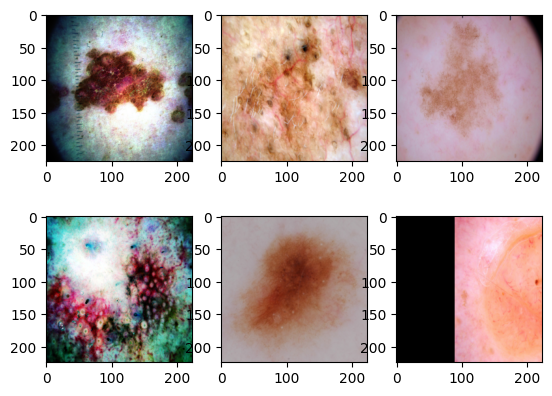

In [9]:
# look at one batch of images
examples = iter(train_loader) # create iterable object
samples, labels = next(examples)  # unpack the batch
# make a plot
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow((samples[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
plt.show()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

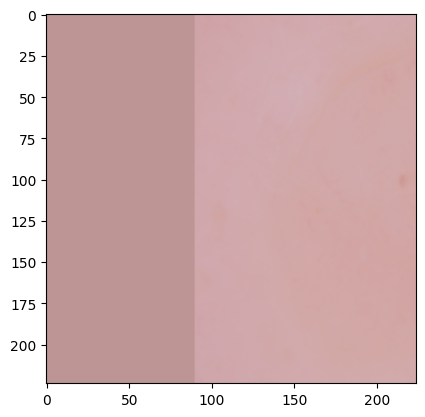

In [10]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Beispiel für die Anzeige:
img = denormalize(samples[i].clone(), [0.7438, 0.5865, 0.5869], [0.0804, 0.1076, 0.1202])
plt.imshow(np.clip(img.permute(1, 2, 0).numpy(), 0, 1))# Device configuration, Prüfe ob GPU verfügbar ist, falls ja, lasse das Modell auf eie GPU laufen, ansonsten CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Wähle ein Modell aus unter: https://pytorch.org/vision/main/models.html
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# mit diesem Code snippet können wir die Parmeter freeze, sodass diese nicht gelernt werden. Ziel Wir trainieren nur den letzten layer, den wir am Ende hinzufügen.
"""
# freeze all model parameters
for param in model.parameters():
    param.requires_grad = False
"""
#num_ftrs = model.heads[0].in_features
#model.heads[0] = torch.nn.Linear(num_ftrs, len(train_dataset.classes))
model.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
"""
Trainieren des Modells
"""
# Trainingsschleife
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    pbar = tqdm(train_loader)
    nr_samples = 0
    labels_global = []
    preds_global = []
    for idx, (images, labels) in enumerate(pbar, start=1):
        # Vorhersage und Verlust berechnen
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Gradienten zurücksetzen, Backwardpropagation und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        nr_samples += images.shape[0]
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels)
        labels_global.extend(labels.tolist())
        preds_global.extend(preds.tolist())
        cnt_acc = running_corrects/nr_samples
        cnt_loss = running_loss/nr_samples
        f1 = f1_score(labels_global, preds_global, average='micro')
        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {cnt_loss:.3f}, Acc: {cnt_acc:.3f}, F1-Score: {f1:.3f}')


Epoch [1/10], Loss: 2.493, Acc: 0.414, F1-Score: 0.414: 100%|██████████| 35/35 [02:46<00:00,  4.76s/it]
Epoch [2/10], Loss: 1.183, Acc: 0.592, F1-Score: 0.592: 100%|██████████| 35/35 [02:47<00:00,  4.78s/it]
Epoch [3/10], Loss: 1.010, Acc: 0.644, F1-Score: 0.644:  43%|████▎     | 15/35 [01:13<01:32,  4.65s/it]

In [10]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
errors = []
model.eval()
running_corrects = 0
nr_samples = 0
for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.data, 1)
    running_corrects += torch.sum(preds == labels)
    nr_samples += images.shape[0]
    if preds != labels:
      errors.append({"image":images.to("cpu")[0], "y_hat":preds.to("cpu")[0].item(), "label":labels.to("cpu")[0].item()})
print()
print(f"Accuracy on Test dataset: {(running_corrects/nr_samples)*100:.3f} %")

100%|██████████| 118/118 [00:11<00:00,  9.88it/s]


Accuracy on Test dataset: 41.525 %


Label: 0, Prediction: 4


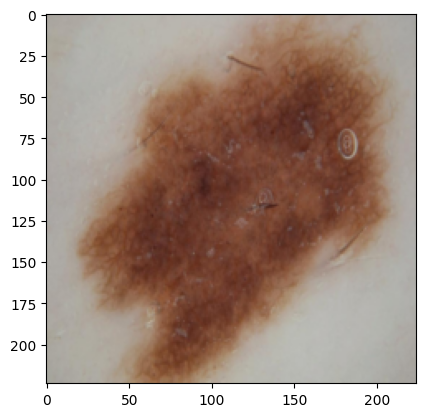

In [9]:
idx = 1
print(f"Label: {errors[idx]['label']}, Prediction: {errors[idx]['y_hat']}")
plt.imshow((errors[idx]['image'].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
plt.show()